<a href="https://colab.research.google.com/github/SolomonM-Kebede/ProjectNLP/blob/main/semval2026_task3_st2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SemEval 2026 Task 3 - Kaggle Notebook Version
## Fine-tuning Pipeline for ABSA with VA Prediction

### 1.  Install dependencies

In [ ]:
!pip install --upgrade transformers datasets accelerate sentencepiece
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.3/512.3 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 29.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2. Imports and Configuration

In [ ]:
import os, re
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import json, random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from tqdm.auto import tqdm
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import f1_score, mean_squared_error

# Check GPU
print(f"GPU Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")


GPU Available: True
GPU Device: Tesla T4
GPU Memory: 15.83 GB


### 3. Configuration

In [ ]:
class Config:
    # Model
    model_name = "google/flan-t5-large"
    max_source_length = 384
    max_target_length = 128

    # Training - FIXED VALUES
    batch_size = 2  # Reduced for stability
    num_epochs = 5
    learning_rate = 3e-5  # Lower learning rate for better convergence
    warmup_ratio = 0.1  # 10% warmup
    gradient_accumulation_steps = 8
    max_grad_norm = 1.0

    # Paths
    train_file = "/content/drive/MyDrive/Colab Notebooks/eng_laptop_train_alltasks.jsonl"
    dev_file = "/content/drive/MyDrive/Colab Notebooks/eng_laptop_dev_task3.jsonl"
    output_dir = "absa_model"

    # Task
    task = "subtask3"  # or "subtask2"
    entity_type = "laptop"  # or "restaurant"

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Early stopping
    patience = 4  # Stop if no improvement for 3 epochs


    use_gradient_checkpointing = True

config = Config()

os.makedirs(config.output_dir, exist_ok=True)


print("Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Task: {config.task}")
print(f"  Batch Size: {config.batch_size}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Device: {config.device}")

Configuration:
  Model: google/flan-t5-large
  Task: subtask3
  Batch Size: 2
  Epochs: 5
  Device: cuda


### Mapping

In [ ]:
def normalize_category(category):
    """Fix common typos in TRAINING data categories"""
    if not category or not isinstance(category, str):
        return category

    category = category.strip().upper()

    # Fix common typos
    fixes = {
        "HARD_DISC": "HARD_DISK",
        "HARD DISK": "HARD_DISK",
        "PRICES": "PRICE",
        "OPERATION&PERFORMANCE": "OPERATION_PERFORMANCE",
        "FANS&COOLING": "FANS_COOLING",
        "FANS & COOLING": "FANS_COOLING",
        "FANS_&_COOLING": "FANS_COOLING",
        "MULTIMEDIA DEVICES": "MULTIMEDIA_DEVICES",
        "POWER SUPPLY": "POWER_SUPPLY",
        "DESIGN & FEATURES": "DESIGN_FEATURES",
    }

    for wrong, correct in fixes.items():
        category = category.replace(wrong, correct)

    return category


def validate_category(category, entity_type="laptop"):
    """
    Validate if category is in the allowed list.
    Returns True if valid, False otherwise.
    """
    if not category or "#" not in category:
        return False

    entity, attribute = category.split("#", 1)

    if entity_type.lower() == "laptop":
        valid_entities = ['LAPTOP', 'DISPLAY', 'KEYBOARD', 'MOUSE', 'MOTHERBOARD', 'CPU',
                         'FANS_COOLING', 'PORTS', 'MEMORY', 'POWER_SUPPLY', 'OPTICAL_DRIVES',
                         'BATTERY', 'GRAPHICS', 'HARD_DISK', 'MULTIMEDIA_DEVICES', 'HARDWARE',
                         'SOFTWARE', 'OS', 'WARRANTY', 'SHIPPING', 'SUPPORT', 'COMPANY']
        valid_attributes = ['GENERAL', 'PRICE', 'QUALITY', 'DESIGN_FEATURES',
                           'OPERATION_PERFORMANCE', 'USABILITY', 'PORTABILITY',
                           'CONNECTIVITY', 'MISCELLANEOUS']
    else:  # restaurant
        valid_entities = ['RESTAURANT', 'FOOD', 'DRINKS', 'AMBIENCE', 'SERVICE', 'LOCATION']
        valid_attributes = ['GENERAL', 'PRICES', 'QUALITY', 'STYLE_OPTIONS', 'MISCELLANEOUS']

    return entity in valid_entities and attribute in valid_attributes

def analyze_categories(data, entity_type="laptop"):
    """Analyze category distribution in training data"""
    from collections import Counter

    category_counts = Counter()

    for item in data:
        quads = item.get("Quadruplet", item.get("quadruplets", []))
        for q in quads:
            cat = q.get("Category", "")
            if cat and "#" in cat:
                category_counts[cat] += 1

    print(f"\nTop 20 Categories in {entity_type} data:")
    print("-" * 60)
    for cat, count in category_counts.most_common(20):
        print(f"  {cat:<40} {count:>5}")

    return category_counts

### 4. Dataset Class

In [ ]:
class ABSADataset(Dataset):
    """
    Dataset that uses gold labels from training data.
    CRITICAL: Does NOT filter out NULL values - they're valid!
    """

    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
        self.task = config.task


        # ONLY normalize categories in training data
        self._normalize_categories()

    def _normalize_categories(self):
        """Normalize categories in training data"""
        for item in self.data:
            if self.task == "subtask3":
                quads = item.get("Quadruplet", item.get("quadruplets", []))
                for q in quads:
                    if "Category" in q:
                        q["Category"] = normalize_category(q["Category"])

    def __len__(self):
        return len(self.data)

    def create_input_text(self, item):
        """Create instruction"""
        text = item.get("Text", item.get("text", ""))

        if self.task == "subtask2":
            instruction = (
                "Extract aspect-opinion-valence-arousal triplets. "
                "Use NULL for missing values. "
                "Format: {\"Triplet\": [{\"Aspect\": \"...\", \"Opinion\": \"...\", \"VA\": \"V.VV#A.AA\"}]}\n\n"
                f"Review: {text}"
            )
        else:
            instruction = (
                "Extract aspect-category-opinion-valence-arousal quadruplets. "
                "Use NULL for missing values. Category format: ENTITY#ATTRIBUTE. "
                "Format: {\"Quadruplet\": [{\"Aspect\": \"...\", \"Category\": \"ENTITY#ATTRIBUTE\", \"Opinion\": \"...\", \"VA\": \"V.VV#A.AA\"}]}\n\n"
                f"Review: {text}"
            )

        return instruction

    def create_target_text(self, item):
        """Create target - use gold labels as-is"""
        if self.task == "subtask2":
            triplets = item.get("Triplet", item.get("triplets", []))
            output = {"Triplet": triplets}
        else:
            quadruplets = item.get("Quadruplet", item.get("quadruplets", []))
            output = {"Quadruplet": quadruplets}

        return json.dumps(output, ensure_ascii=False)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self.create_input_text(item)
        target_text = self.create_target_text(item)

        input_encoding = self.tokenizer(
            input_text,
            max_length=config.max_source_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=config.max_target_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        labels = target_encoding["input_ids"].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            "input_ids": input_encoding["input_ids"].squeeze(),
            "attention_mask": input_encoding["attention_mask"].squeeze(),
            "labels": labels
        }

### 7.  Load Data

In [ ]:
print("\n" + "="*80)
print("="*80)

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data


# Load data
print("\nLoading data...")
with open(config.train_file, "r", encoding="utf-8") as f:
    all_data = [json.loads(line) for line in f if line.strip()]

print(f"Total training data: {len(all_data)}")

# Split data - 90% train, 10% test
random.seed(42)
random.shuffle(all_data)

split_idx = int(0.9 * len(all_data))
train_data = all_data[:split_idx]
test_data = all_data[split_idx:]

# Load dev data (unlabeled)
with open(config.dev_file, "r", encoding="utf-8") as f:
    dev_data = [json.loads(line) for line in f if line.strip()]

print(f"Training: {len(train_data)}")
print(f"Test (for metrics): {len(test_data)}")
print(f"Dev (unlabeled, for submission): {len(dev_data)}")

# Show sample
print("\nSample training example:")
print(json.dumps(train_data[0], indent=2, ensure_ascii=False))





Loading data...
Total training data: 4076
Training: 3668
Test (for metrics): 408
Dev (unlabeled, for submission): 200

Sample training example:
{
  "ID": "laptop_quad_train_2127",
  "Text": "picks up wireless signals weakly !",
  "Quadruplet": [
    {
      "Aspect": "wireless signals",
      "Category": "LAPTOP#CONNECTIVITY",
      "Opinion": "weakly",
      "VA": "2.50#7.25"
    }
  ]
}


### 6. Load Model and Tokenizer

In [ ]:
print("\n" + "="*80)
print(f"Loading Model: {config.model_name}")
print("="*80)

tokenizer = T5Tokenizer.from_pretrained(config.model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
model = T5ForConditionalGeneration.from_pretrained(config.model_name)
model.gradient_checkpointing_enable()
model.to(config.device)

print(f"\nModel loaded successfully!")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M")



Loading Model: google/flan-t5-large


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]


Model loaded successfully!
Model parameters: 783.15M


### 8. Create Datasets and Dataloaders

In [ ]:
print("\n" + "="*80)
print("Creating Datasets...")
print("="*80)



# Create datasets - NOTE: is_training=True for train/test, False for dev
train_dataset = ABSADataset(train_data, tokenizer, config=config)
test_dataset = ABSADataset(test_data, tokenizer, config=config)
dev_dataset = ABSADataset(dev_data, tokenizer, config=config)
print(f"  Clean training examples: {len(train_dataset)}")
print(f"  Clean test examples: {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_dataloader)},Test batches: {len(test_dataloader)}, Dev batches: {len(dev_dataloader)}")

print(f"Training examples: {len(train_dataset)},Test examples:{len(test_dataset)} Dev examples: {len(dev_dataset)}")



Creating Datasets...
  Clean training examples: 3668
  Clean test examples: 408
Train batches: 1834,Test batches: 204, Dev batches: 100
Training examples: 3668,Test examples:408 Dev examples: 200


### 9. Setup Optimizer and Scheduler

In [ ]:
import bitsandbytes as bnb
# Setup optimizer
num_training_steps = len(train_dataloader) * config.num_epochs // config.gradient_accumulation_steps
num_warmup_steps = int(num_training_steps * config.warmup_ratio)

#optimizer = AdamW(model.parameters(), lr=config.learning_rate)
optimizer = bnb.optim.AdamW8bit(model.parameters(), lr=config.learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

print(f"\nTraining setup:")
print(f"  Total steps: {num_training_steps}")
print(f"  Warmup steps: {num_warmup_steps}")


Training setup:
  Total steps: 1146
  Warmup steps: 114


### 5. Helper Functions

In [ ]:



def train_epoch(model, dataloader, optimizer, scheduler, device, config):
    model.train()
    total_loss = 0
    step_losses = [] # <--- NEW: To capture the raw signal jitter

    progress_bar = tqdm(dataloader, desc="Training")

    for step, batch in enumerate(progress_bar):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss / config.gradient_accumulation_steps
        loss.backward()

        # Log the raw loss for our signal graph
        step_losses.append(loss.item() * config.gradient_accumulation_steps)

        if (step + 1) % config.gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * config.gradient_accumulation_steps
        progress_bar.set_postfix({'loss': loss.item() * config.gradient_accumulation_steps})

    return total_loss / len(dataloader), step_losses

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", ncols=100):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            total_loss += outputs.loss.item()
            num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

def generate_sample_predictions(model, tokenizer, dataloader, device, num_samples=5):
    model.eval()
    samples = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_samples:
                break
            input_ids = batch["input_ids"][:1].to(device)
            attention_mask = batch["attention_mask"][:1].to(device)
            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask,
                                     max_length=config.max_target_length, num_beams=4, early_stopping=True)
            pred = tokenizer.decode(outputs[0], skip_special_tokens=True)
            samples.append(pred)
    return samples

def is_valid_element(item, field):
    """Check if element is valid (not NULL or empty)"""
    value = item.get(field, "")
    if not value:
        return False
    value_str = str(value).strip().upper()
    return value_str not in ["NULL", "NONE", ""]


def compute_f1(pred_list, gold_list, include_category=False):
    """


    Only compares non-NULL Aspect+Opinion pairs
    """
    pred_tuples = []
    gold_tuples = []

    # Build prediction tuples (only if Aspect AND Opinion are not NULL)
    for p in pred_list:
        if is_valid_element(p, "Aspect") and is_valid_element(p, "Opinion"):
            if include_category:
                # Full match: Aspect + Category + Opinion
                if is_valid_element(p, "Category"):
                    pred_tuples.append((
                        str(p.get("Aspect", "")).strip().upper(),
                        str(p.get("Category", "")).strip().upper(),
                        str(p.get("Opinion", "")).strip().upper()
                    ))
            else:
                # Partial match: Aspect + Opinion
                pred_tuples.append((
                    str(p.get("Aspect", "")).strip().upper(),
                    str(p.get("Opinion", "")).strip().upper()
                ))

    # Build gold tuples (only if Aspect AND Opinion are not NULL)
    for g in gold_list:
        if is_valid_element(g, "Aspect") and is_valid_element(g, "Opinion"):
            if include_category:
                if is_valid_element(g, "Category"):
                    gold_tuples.append((
                        str(g.get("Aspect", "")).strip().upper(),
                        str(g.get("Category", "")).strip().upper(),
                        str(g.get("Opinion", "")).strip().upper()
                    ))
            else:
                gold_tuples.append((
                    str(g.get("Aspect", "")).strip().upper(),
                    str(g.get("Opinion", "")).strip().upper()
                ))

    # Convert to sets
    pred_set = set(pred_tuples)
    gold_set = set(gold_tuples)

    if not gold_set:
        return 0.0, 0.0, 0.0

    tp = len(pred_set & gold_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return f1, precision, recall


def compute_rmse(pred_va, gold_va):
    pred_vals, gold_vals = [], []

    for p, g in zip(pred_va, gold_va):
        if p == "NULL" or g == "NULL" or "#" not in str(p) or "#" not in str(g):
            continue
        try:
            p_v, p_a = map(float, p.split("#"))
            g_v, g_a = map(float, g.split("#"))
            pred_vals.append([p_v, p_a])
            gold_vals.append([g_v, g_a])
        except:
            continue

    if not pred_vals:
        return np.nan, np.nan

    pred_vals = np.array(pred_vals)
    gold_vals = np.array(gold_vals)

    try:
        # Try the modern way first (scikit-learn 1.4+)
        from sklearn.metrics import root_mean_squared_error
        rmse_v = root_mean_squared_error(gold_vals[:, 0], pred_vals[:, 0])
        rmse_a = root_mean_squared_error(gold_vals[:, 1], pred_vals[:, 1])
    except ImportError:
        # Fallback for older versions
        rmse_v = mean_squared_error(gold_vals[:, 0], pred_vals[:, 0], squared=False)
        rmse_a = mean_squared_error(gold_vals[:, 1], pred_vals[:, 1], squared=False)

    return rmse_v, rmse_a

def compute_ccc(pred_va, gold_va):
    """Compute Concordance Correlation Coefficient"""
    def ccc_single(x, y):
        x = np.array(x)
        y = np.array(y)
        if len(x) < 2:
            return float("nan")
        mean_x, mean_y = np.mean(x), np.mean(y)
        cov = np.mean((x - mean_x) * (y - mean_y))
        var_x, var_y = np.var(x), np.var(y)
        return 2 * cov / (var_x + var_y + (mean_x - mean_y)**2 + 1e-8)

    pred_vals, gold_vals = [], []

    for p, g in zip(pred_va, gold_va):
        if not p or not g:
            continue
        p_str = str(p).strip().upper()
        g_str = str(g).strip().upper()
        if p_str == "NULL" or g_str == "NULL":
            continue

        try:
            p_parts = str(p).split("#")
            g_parts = str(g).split("#")
            if len(p_parts) == 2 and len(g_parts) == 2:
                pred_vals.append([float(p_parts[0]), float(p_parts[1])])
                gold_vals.append([float(g_parts[0]), float(g_parts[1])])
        except:
            continue

    if not pred_vals or not gold_vals or len(pred_vals) < 2:
        return float("nan"), float("nan")

    pred_vals = np.array(pred_vals)
    gold_vals = np.array(gold_vals)

    ccc_v = ccc_single(pred_vals[:, 0], gold_vals[:, 0])
    ccc_a = ccc_single(pred_vals[:, 1], gold_vals[:, 1])

    return ccc_v, ccc_a





### 10. Training Loop

In [ ]:
print("\n" + "="*80)
print("Starting Training")
print("="*80)

best_f1 = -1.0
patience_counter = 0
all_raw_step_losses = [] # Reset/Initialize the signal data

training_history = {
    "train_loss": [],
    "test_loss": [],
    "test_f1_partial": [],
    "test_f1_full": [],
    "best_epoch": 0
}

for epoch in range(config.num_epochs):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{config.num_epochs}")
    print(f"{'='*80}")

    # --- 1. Train ---
    # UNPACKING: Capture the average for history and the raw list for the signal graph
    train_loss_avg, epoch_step_losses = train_epoch(model, train_dataloader, optimizer, scheduler, config.device, config)

    all_raw_step_losses.extend(epoch_step_losses)
    training_history["train_loss"].append(train_loss_avg)

    print(f"\nTrain Loss: {train_loss_avg:.4f}") # Changed from train_loss to train_loss_avg

    # --- 2. Evaluate Loss ---
    test_loss = evaluate(model, test_dataloader, config.device)
    training_history["test_loss"].append(test_loss)
    print(f"Test Loss: {test_loss:.4f}")

    # --- 3. Generate Predictions & Metrics ---
    if (epoch + 1) % 2 == 0 or epoch == config.num_epochs - 1:
        print("\n" + "="*60)
        print("Generating Predictions & Computing Metrics")
        print("="*60)

        all_f1_partial, all_f1_full = [], []
        all_precision_partial, all_recall_partial = [], []
        all_precision_full, all_recall_full = [], []
        all_pred_va, all_gold_va = [], []

        parse_success = 0
        parse_fail = 0

        model.eval()
        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(test_dataloader, desc="Predictions", ncols=100)):
                input_ids = batch["input_ids"].to(config.device)
                attention_mask = batch["attention_mask"].to(config.device)

                outputs = model.generate(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    max_length=config.max_target_length,
                    num_beams=4,
                    early_stopping=True
                )

                batch_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

                for i, pred_text in enumerate(batch_predictions):
                    idx = batch_idx * config.batch_size + i
                    if idx >= len(test_data):
                        break

                    if batch_idx == 0 and i == 0:
                        print(f"\n[DEBUG] Raw Model Output: {pred_text}")

                    gold_item = test_data[idx]
                    gold_key = "Quadruplet" if config.task == "subtask3" else "Triplet"
                    gold_list = gold_item.get(gold_key, [])

                    # Robust extraction
                    pred_list = []
                    aspects = re.findall(r'"Aspect"\s*:\s*"([^"]*)"', pred_text)
                    categories = re.findall(r'"Category"\s*:\s*"([^"]*)"', pred_text)
                    opinions = re.findall(r'"Opinion"\s*:\s*"([^"]*)"', pred_text)
                    va_scores = re.findall(r'"VA"\s*:\s*"([^"]*)"', pred_text)

                    # Zip based on aspects found to handle cases where some fields might be missing
                    for j in range(len(aspects)):
                        pred_list.append({
                            "Aspect": aspects[j],
                            "Category": categories[j] if j < len(categories) else "LAPTOP#GENERAL",
                            "Opinion": opinions[j] if j < len(opinions) else "NULL",
                            "VA": va_scores[j] if j < len(va_scores) else "0.00#0.00"
                        })

                    if pred_list:
                        parse_success += 1
                    else:
                        parse_fail += 1

                    if gold_list:
                        # Partial F1
                        f1, p, r = compute_f1(pred_list, gold_list, include_category=False)
                        all_f1_partial.append(f1)
                        all_precision_partial.append(p)
                        all_recall_partial.append(r)

                        # Full F1
                        if config.task == "subtask3":
                            f1_full, p_full, r_full = compute_f1(pred_list, gold_list, include_category=True)
                            all_f1_full.append(f1_full)
                            all_precision_full.append(p_full)
                            all_recall_full.append(r_full)

                        all_pred_va.extend([x.get("VA", "NULL") for x in pred_list])
                        all_gold_va.extend([x.get("VA", "NULL") for x in gold_list])

        print(f"\nParsing Result: Success={parse_success}, Failed={parse_fail}")

        # --- 4. Statistics Calculation ---
        if all_f1_partial:
            mean_f1_partial = np.mean(all_f1_partial)
            training_history["test_f1_partial"].append(mean_f1_partial)

            print(f"\n📊 PARTIAL MATCH (Aspect + Opinion):")
            print(f"  F1: {mean_f1_partial:.4f} | P: {np.mean(all_precision_partial):.4f} | R: {np.mean(all_recall_partial):.4f}")

            if config.task == "subtask3" and all_f1_full:
                mean_f1_full = np.mean(all_f1_full)
                training_history["test_f1_full"].append(mean_f1_full)
                print(f"📊 FULL MATCH (Category): F1: {mean_f1_full:.4f}")

            rmse_v, rmse_a = compute_rmse(all_pred_va, all_gold_va)
            ccc_v, ccc_a = compute_ccc(all_pred_va, all_gold_va)
            if not np.isnan(rmse_v):
                print(f"📊 RMSE: V={rmse_v:.4f}, A={rmse_a:.4f} | CCC: V={ccc_v:.4f}, A={ccc_a:.4f}")

            # --- 5. Save Best Model ---
            if mean_f1_partial > best_f1:
                best_f1 = mean_f1_partial
                training_history["best_epoch"] = epoch + 1
                patience_counter = 0
                print(f"✅ NEW BEST MODEL at Epoch {epoch+1}")
                model.save_pretrained(config.output_dir)
                tokenizer.save_pretrained(config.output_dir)
            else:
                patience_counter += 1
        else:
            print("\n⚠️ Warning: No valid predictions extracted.")

    if patience_counter >= config.patience:
        print(f"\nEarly stopping triggered.")
        break

print("\n" + "="*80)
print(f"Training Complete. Best F1: {best_f1:.4f}")
print("="*80)


Starting Training

Epoch 1/5


Training:   0%|          | 0/1834 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...



Train Loss: 0.5337


Evaluating:   0%|                                                           | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1986

Epoch 2/5


Training:   0%|          | 0/1834 [00:00<?, ?it/s]


Train Loss: 0.2142


Evaluating:   0%|                                                           | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1735

Generating Predictions & Computing Metrics


Predictions:   0%|                                                          | 0/204 [00:00<?, ?it/s]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.25#5.12"]

Parsing Result: Success=408, Failed=0

📊 PARTIAL MATCH (Aspect + Opinion):
  F1: 0.4005 | P: 0.4424 | R: 0.3858
📊 FULL MATCH (Category): F1: 0.2509
📊 RMSE: V=2.6288, A=1.7157 | CCC: V=0.0728, A=0.0556
✅ NEW BEST MODEL at Epoch 2

Epoch 3/5


Training:   0%|          | 0/1834 [00:00<?, ?it/s]


Train Loss: 0.1884


Evaluating:   0%|                                                           | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1629

Epoch 4/5


Training:   0%|          | 0/1834 [00:00<?, ?it/s]


Train Loss: 0.1759


Evaluating:   0%|                                                           | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1596

Generating Predictions & Computing Metrics


Predictions:   0%|                                                          | 0/204 [00:00<?, ?it/s]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.62#4.62"]

Parsing Result: Success=408, Failed=0

📊 PARTIAL MATCH (Aspect + Opinion):
  F1: 0.4172 | P: 0.4424 | R: 0.4114
📊 FULL MATCH (Category): F1: 0.2714
📊 RMSE: V=2.7259, A=1.8546 | CCC: V=0.0315, A=0.0400
✅ NEW BEST MODEL at Epoch 4

Epoch 5/5


Training:   0%|          | 0/1834 [00:00<?, ?it/s]


Train Loss: 0.1698


Evaluating:   0%|                                                           | 0/204 [00:00<?, ?it/s]

Test Loss: 0.1598

Generating Predictions & Computing Metrics


Predictions:   0%|                                                          | 0/204 [00:00<?, ?it/s]


[DEBUG] Raw Model Output: "Quadruplet": ["Aspect": "NULL", "Category": "LAPTOP#OPERATION_PERFORMANCE", "Opinion": "NULL", "VA": "4.62#4.62"]

Parsing Result: Success=408, Failed=0

📊 PARTIAL MATCH (Aspect + Opinion):
  F1: 0.4203 | P: 0.4473 | R: 0.4154
📊 FULL MATCH (Category): F1: 0.2772
📊 RMSE: V=2.8171, A=1.8762 | CCC: V=-0.0211, A=-0.0296
✅ NEW BEST MODEL at Epoch 5

Training Complete. Best F1: 0.4203


In [ ]:
with open('t5_base_history.json', 'w') as f:
    json.dump(training_history, f)

### 11. Plot Training Curves

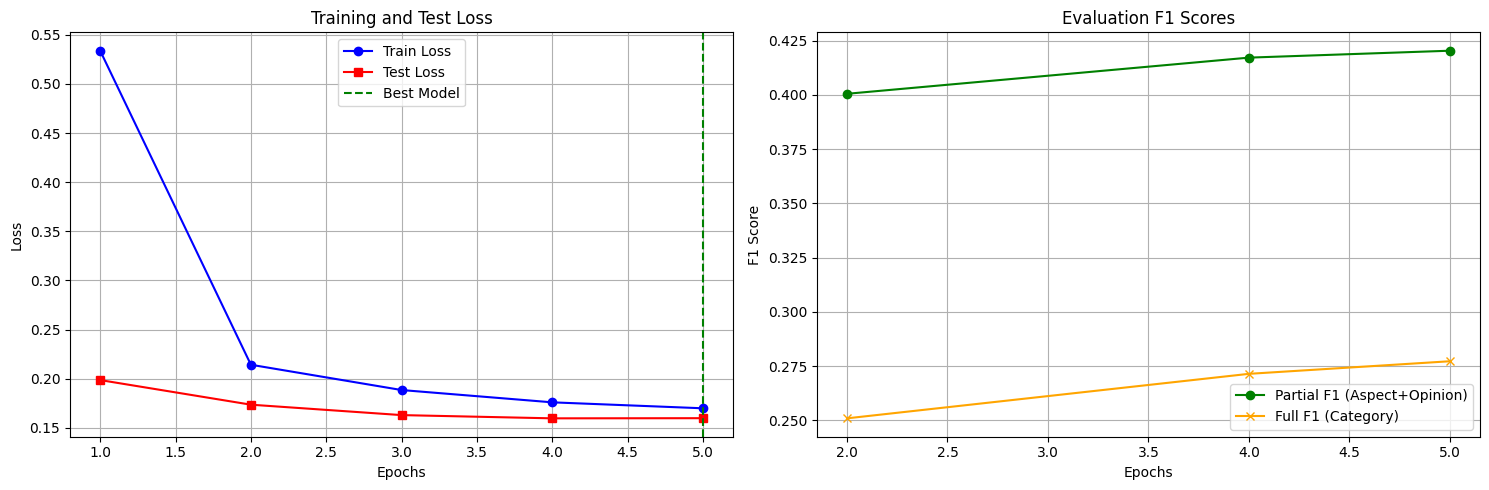

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    epochs = range(1, len(history["train_loss"]) + 1)
    # We only have F1 scores for the epochs where evaluation ran (every 2nd epoch)
    f1_epochs = [i for i, val in enumerate(history["test_f1_partial"], 1) if val is not None]

    plt.figure(figsize=(15, 5))

    # Plot 1: Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], 'b-o', label='Train Loss')
    plt.plot(epochs, history["test_loss"], 'r-s', label='Test Loss')
    plt.axvline(x=training_history["best_epoch"], color='g', linestyle='--', label='Best Model')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: F1 Scores
    plt.subplot(1, 2, 2)
    # Aligning the F1 scores to the correct epochs (2, 4, 6, 8)
    eval_steps = [i for i in epochs if i % 2 == 0 or i == len(epochs)]

    plt.plot(eval_steps, history["test_f1_partial"], 'g-o', label='Partial F1 (Aspect+Opinion)')
    if history["test_f1_full"]:
        plt.plot(eval_steps, history["test_f1_full"], 'orange', marker='x', label='Full F1 (Category)')

    plt.title('Evaluation F1 Scores')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Run the plotter
plot_training_results(training_history)

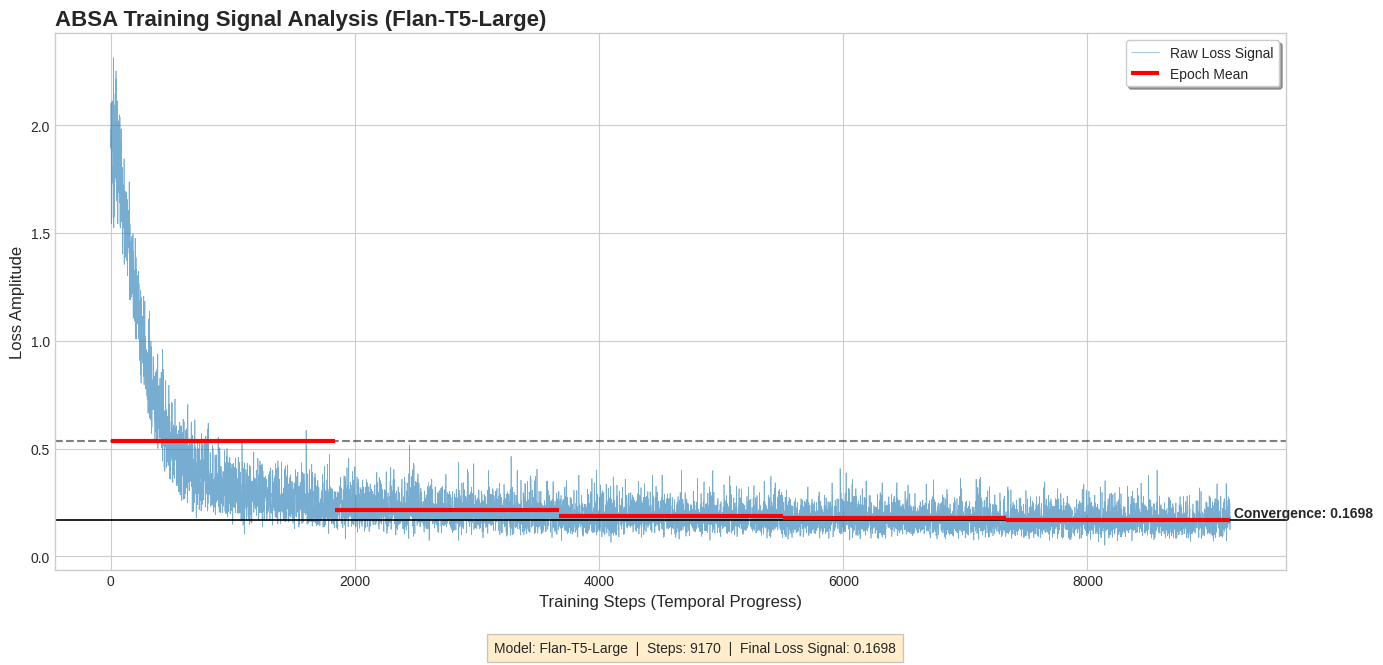

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_scientific_signal_loss(all_step_losses, num_epochs):
    plt.style.use('seaborn-v0_8-whitegrid') # Clean scientific look
    plt.figure(figsize=(14, 7))

    # 1. The Raw Signal (The Blue Jitter)
    steps = np.arange(len(all_step_losses))
    plt.plot(steps, all_step_losses, color='#1f77b4', linewidth=0.5, alpha=0.6, label='Raw Loss Signal')

    # 2. The Detected Mean (The Red Steps)
    # Calculate the average loss for each epoch "window"
    steps_per_epoch = len(all_step_losses) // num_epochs
    epoch_means = []
    for i in range(num_epochs):
        start = i * steps_per_epoch
        end = (i + 1) * steps_per_epoch
        mean_val = np.mean(all_step_losses[start:end])
        epoch_means.append(mean_val)
        # Draw the horizontal red line for this epoch
        plt.hlines(mean_val, start, end, colors='red', lw=3, zorder=5, label='Epoch Mean' if i==0 else "")

    # 3. Threshold / Convergence Lines (The Black Borders)
    initial_threshold = epoch_means[0]
    final_limit = epoch_means[-1]
    plt.axhline(y=initial_threshold, color='black', linestyle='--', alpha=0.5)
    plt.axhline(y=final_limit, color='black', linestyle='-', lw=1.2)

    # Annotate the convergence limit
    plt.text(len(all_step_losses), final_limit, f' Convergence: {final_limit:.4f}',
             verticalalignment='bottom', fontweight='bold')

    # 4. Adding "Detector" Labels (Bottom of graph)
    plt.title('ABSA Training Signal Analysis (Flan-T5-Large)', fontsize=16, loc='left', fontweight='bold')
    plt.xlabel('Training Steps (Temporal Progress)', fontsize=12)
    plt.ylabel('Loss Amplitude', fontsize=12)

    # Bottom metadata bar
    info_text = f"Model: Flan-T5-Large  |  Steps: {len(all_step_losses)}  |  Final Loss Signal: {final_limit:.4f}"
    plt.figtext(0.5, 0.01, info_text, ha="center", fontsize=10, bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

    plt.legend(loc='upper right', frameon=True, shadow=True)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

draw_scientific_signal_loss(all_raw_step_losses, config.num_epochs)

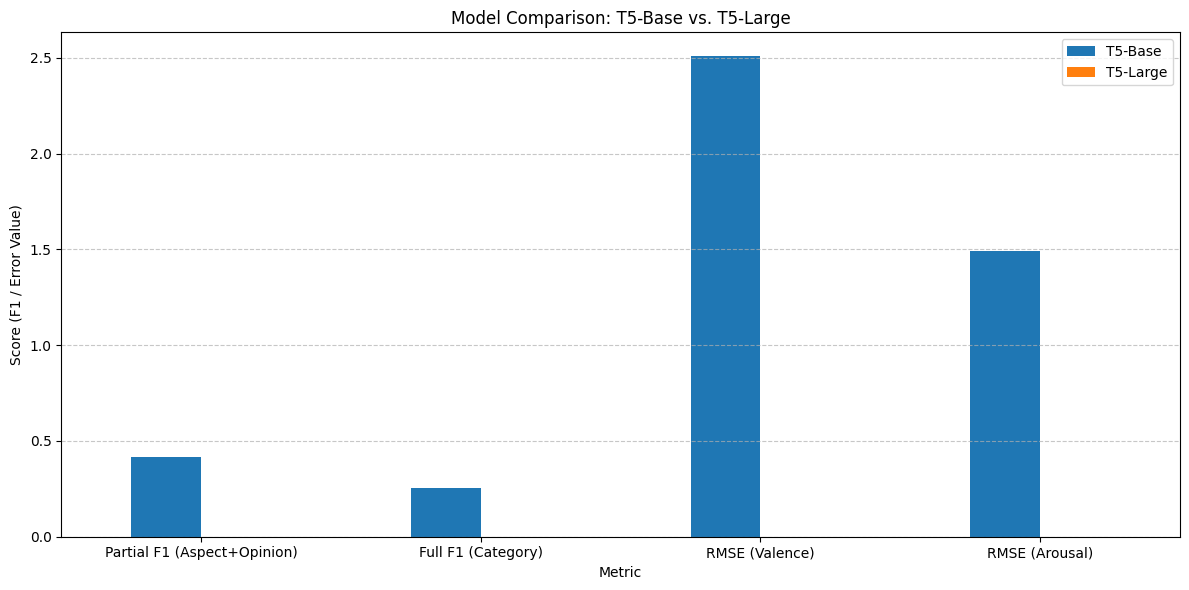

Comparison Table:
                     Metric  T5-Base  T5-Large
Partial F1 (Aspect+Opinion)   0.4150       0.0
         Full F1 (Category)   0.2522       0.0
             RMSE (Valence)   2.5071       0.0
             RMSE (Arousal)   1.4887       0.0


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from your experiments
# Replace these with your actual best results
results = {
    "Metric": ["Partial F1 (Aspect+Opinion)", "Full F1 (Category)", "RMSE (Valence)", "RMSE (Arousal)"],
    "T5-Base": [0.4150, 0.2522, 2.5071, 1.4887], # Your previous bests
    "T5-Large": [0.0, 0.0, 0.0, 0.0]            # Fill these in when Epoch 8 finishes
}

# Add your new T5-Large best scores here manually if needed:
# results["T5-Large"] = [new_f1_partial, new_f1_full, new_rmse_v, new_rmse_a]

df = pd.DataFrame(results)

# Create the visualization
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting F1 Scores (Higher is better)
df.plot(x="Metric", y=["T5-Base", "T5-Large"], kind="bar", ax=ax1)
plt.title("Model Comparison: T5-Base vs. T5-Large")
plt.ylabel("Score (F1 / Error Value)")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("Comparison Table:")
print(df.to_string(index=False))

### 12. Generate Predictions on Dev Set

In [ ]:
import re
import json
from tqdm import tqdm

print("\n" + "="*80)
print("Generating Dev Predictions (for submission) using robust extraction")
print("="*80)

# Load the best model saved during training
best_model = T5ForConditionalGeneration.from_pretrained(config.output_dir).to(config.device)
best_model.eval()

processed_predictions = []

def extract_prediction(text, task):
    """Robust extraction that handles missing commas, brackets, or weird ordering"""
    result = []

    # 1. Try strict JSON first
    try:
        # Clean potential leading/trailing garbage
        clean_text = text.strip()
        if not clean_text.startswith('{'):
            clean_text = "{" + clean_text.split('{', 1)[-1] if '{' in clean_text else clean_text
        parsed = json.loads(clean_text)
        key = "Triplet" if task=="subtask2" else "Quadruplet"
        items = parsed.get(key, [])
        if items: return items
    except:
        pass

    # 2. Robust Regex Fallback (Order-independent)
    # We find all occurrences of each field independently
    aspects = re.findall(r'"Aspect"\s*:\s*"([^"]*)"', text)
    opinions = re.findall(r'"Opinion"\s*:\s*"([^"]*)"', text)
    va_scores = re.findall(r'"VA"\s*:\s*"([^"]*)"', text)

    if task == "subtask3":
        categories = re.findall(r'"Category"\s*:\s*"([^"]*)"', text)
        # Zip based on the number of Aspects found
        for i in range(len(aspects)):
            result.append({
                "Aspect": aspects[i],
                "Category": categories[i] if i < len(categories) else "LAPTOP#GENERAL",
                "Opinion": opinions[i] if i < len(opinions) else "NULL",
                "VA": va_scores[i] if i < len(va_scores) else "0.00#0.00"
            })
    else: # subtask2
        for i in range(len(aspects)):
            result.append({
                "Aspect": aspects[i],
                "Opinion": opinions[i] if i < len(opinions) else "NULL",
                "VA": va_scores[i] if i < len(va_scores) else "0.00#0.00"
            })

    return result

# --- inference loop ---
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(dev_dataloader, desc="Dev", ncols=100)):
        input_ids = batch["input_ids"].to(config.device)
        attention_mask = batch["attention_mask"].to(config.device)

        outputs = best_model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=config.max_target_length,
            num_beams=4,
            early_stopping=True
        )

        batch_predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        for i, pred_text in enumerate(batch_predictions):
            idx = batch_idx * config.batch_size + i
            if idx >= len(dev_data):
                break

            # Competition standard: Use the ID from the source data
            res_id = dev_data[idx].get("ID", dev_data[idx].get("id", str(idx)))
            key = "Triplet" if config.task == "subtask2" else "Quadruplet"

            extracted = extract_prediction(pred_text, config.task)

            # Ensure we always return a list for the key, even if empty
            processed_predictions.append({
                "ID": res_id,
                key: extracted
            })

# --- Save JSONL ---
output_file = "dev_predictions.jsonl"
with open(output_file, "w", encoding="utf-8") as f:
    for res in processed_predictions:
        f.write(json.dumps(res, ensure_ascii=False) + "\n")

print(f"\n✅ Saved {len(processed_predictions)} predictions to {output_file}")


Generating Dev Predictions (for submission) using robust extraction


Dev: 100%|████████████████████████████████████████████████████████| 100/100 [08:11<00:00,  4.92s/it]


✅ Saved 200 predictions to dev_predictions.jsonl


### 13. Download Model

In [ ]:
print("\n" + "="*80)
print("Preparing Model for Download")
print("="*80)

# Create a zip file of the model
import shutil

zip_path = "absa_model"
shutil.make_archive(zip_path, 'zip', config.output_dir)

print(f"✅ Model archived!")
print(f"\nTo download your trained model:")
print(f"  1. Look in the right sidebar under 'Output'")
print(f"  2. Download 'absa_model.zip'")
print(f"  3. Extract and use with inference script")

print("\n" + "="*80)
print("🎉 All Done!")
print("="*80)
print("\nNext steps:")
print("  1. Download absa_model.zip from Output")
print("  2. Use the inference script to make predictions")
print("  3. Evaluate on test set")



Preparing Model for Download
✅ Model archived!

To download your trained model:
  1. Look in the right sidebar under 'Output'
  2. Download 'absa_model.zip'
  3. Extract and use with inference script

🎉 All Done!

Next steps:
  1. Download absa_model.zip from Output
  2. Use the inference script to make predictions
  3. Evaluate on test set
